# Introduction to Bayesian statistics for climate scientists

## Part 2. Model fitting with MCMC

In the first session we covered Bayesian probability, Bayes Theorem and explicit calculation of the posterior.  We now move onto a more practical approach where we use the Stan package to fit Bayesian models using a Markov Chain Monte Carlo approach.  We'll be doing this by fitting a normal distribution to some data and then looking at how you infer correlation with Bayesian methods.

In this session we will cover:

1) fitting models using PyMC3

2) flowing through parameter space with Hamiltonian Monte Carlo

3) evaluate model fits

4) inferring the correlation parameter 

We'll start as ever by doing some imports.


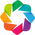

In [2]:
# Import packages for loading and analysing data
import numpy as np
import pandas as pd
# Turn off a type of warning that indicates something might change in future versions of a package
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import the Bayesian pymc3 package
import pymc3 as pm
# PyMC3 is built on top of Theano. Import the Theano array module called theano.tensor to help build models with PyMC3
import theano.tensor as ttens
import scipy.stats as stats

# Sklearn is a python python machine learning library. We use the preprocessing package from Sklearn to
# standardize our data before fitting the model
from sklearn import preprocessing

# Visualisation imports
# Use holoviews to make interactive plots
import holoviews as hv
# We make a plot using the bokeh module directly as well
from bokeh.plotting import figure, show
import matplotlib.pyplot as plt
# Import the HTML module to display a table using html code
from IPython.core.display import HTML

# Holoviews builds on top of either the Matplotlib or Bokeh plotting library. Choose to use Bokeh 
# in these plots as interactive plots work very well with Bokeh
hv.notebook_extension('bokeh')
# Some plots that are made directly with PyMC3 use matplotlib. Set the following command so that the 
# plots appear in the notebook rather than in a separate window
%matplotlib inline

# Fitting models using PyMC3

In order to fit a model, we're going to need some data. We will use daily mean temperature and precipitation observations for Stockholm [downloaded from SMHI](https://www.smhi.se/klimatdata).  We will use this data to understand aspects such as the mean and variability of the data, correlations within the dataset and linear trends.

We read in this data from a .csv file in the data sub-directory using the Pandas package. The .csv files is called temp_rain_1960_to_2017.csv.

The data will be loaded as a **dataframe**.  A dataframe has columns of data where each column has a name and each row has an index such as a date or a location.

In [3]:
# Create a dataframe df that holds the weather data
df = pd.read_csv('data/temp_rain_1960_to_2017.csv',index_col='date', parse_dates=True)
# Print the first five rows of the dataframe to the screen
print(df.head())

            precip  temp
date                    
1961-01-06     0.5   0.8
1961-01-07     3.3   0.7
1961-01-08     0.1  -5.0
1961-01-09     0.4  -6.5
1961-01-10     2.5   0.4


This dataset runs from early 1961 to the end of September in 2017.  If you want to learn more about how useful the Pandas package is for data analysis you can work through this material I prepared [for another workshop that focuses on data analysis with python](https://github.com/braaannigan/climate_python_intro).

## Fitting a normal distribution
In our example here we fit a normal (or Gaussian) distribution to the dataset.  We use this as an example because:

**1)** it shows how to fit a parameteric distribution to a dataset

**2)** we can do an example of model evaluation

**3)** a similar procedure is used to estimate correlation and regression coefficients.

As a reminder, normal distributions are 'bell-curves'.  Normal distributions are *parameterised* by their *mean* ($\mu$) and standard deviation ($\sigma$).  Some normal distributions with different means and standard deviations are plotting below.

In [19]:
%output size=120
x_range = np.linspace(-10,10,200)
norm1 = hv.Curve( (x_range, stats.norm.pdf(x_range,0,2)), 
         kdims=['x'],vdims=['Probability density'],
         label = "mean = 0, standard dev. = 2")
norm2 = hv.Curve( (x_range, stats.norm.pdf(x_range,2,1)), 
         kdims=['x'],vdims=['Probability density'],
         label = "mean = 2, standard dev. = 1")
norm1*norm2

:Overlay
   .Curve.Mean_equals_0_comma_standard_dev_full_stop_equals_2 :Curve   [x]   (Probability density)
   .Curve.Mean_equals_2_comma_standard_dev_full_stop_equals_1 :Curve   [x]   (Probability density)

### Visual inspection

Before fitting the model we first inspect its properties visually.  When fitting this model, we split our data into a **training** dataset and a **testing** dataset.  In this case we take the training set to be the period before 1990 and the testing set to be the period after 1990.  We will return to the testing dataset in Part 3 on linear regression.

In [20]:
%%opts Histogram [tools=['hover'] height=500 width=600] (alpha=0.6)
%%opts Histogram.newer [height=300 width=400] 

# Create a dataframe with only winter time temperature data
winter = df.temp.loc[df.index.month.isin([1,2,12])]

# Create a normalised histogram of the daily temperature data
bin_edges = np.linspace(-30,12)
older_freqs,bin_edges = np.histogram(winter, bin_edges, normed=True)

h1 = hv.Histogram(older_freqs, bin_edges, 
                  kdims=['Temperature degrees C'], vdims = ['Frequency (%)'],
                  label = 'Winter daily mean temperatures')
h1

:Histogram   [Temperature degrees C]   (Frequency (%))

A visual inspection shows that the data is clearly not a normal distribtion in the strict sense. In particular, it looks like the dataset has a negative skew with a longer left tail of colder values.  We'll come back to this point after we've fit the model, however.

### Exercise
Estimate what the parameters $\mu$ and $\sigma$ will be for the model fit.

## Specifying the model mathematically
The parameters of the normal distribution are $\theta = (\mu,\sigma)$ where $\mu$ is the mean and $\sigma$ is the standard deviation of the distribution.

We must specify the model mathematically first.  The **likelihood** of the parameters conditioned on the data $y$ is:
$$y \sim \mathcal{N}(\mu, \sigma)$$


We must also specify the prior distributions for $\mu$ and $\sigma$.  
These priors set out what we think a sensible range for the $\mu$ and $\sigma$ should be.  In this case we choose:
$$ \mu \sim \mathcal{N}(0, 2)$$
and 
$$ \sigma \sim \mathcal{N}^{+}(0, 5)$$

The information we are encoding with these priors is that we expect the mean to be somewhere in the range from about -4 to +4 while the standard deviation must be positive and should be less than about 10.  


### PyMC3 code for model fitting
The model code for fitting a normal distribution using a Bayesian approach is: 

In [1]:
def gaussian_fit(data, mu_prior, sigma_prior, samples = 1000, njobs = 2):
    """Fit a normal distribution model conditioned on the data
    
    data is the 1D training dataset
    mu_prior is a dictionary with the parameters of a Normal distribution e.g. mu_prior = {'mean': 0, 'sd': 10}
    sigma_prior is a dictionary with the parameters of a Half-Normal distribution e.g. sigma_prior = {'sd': 10}
    output: 'trace' is the trace of the model fit, 'map_est' is the estimates of the most likely values 
    """

    with pm.Model() as model: 
        # Specify priors
        mu = pm.Normal('mu', mu = mu_prior['mean'], sd = mu_prior['sd']) 
        sigma = pm.HalfNormal('sigma', sd = sigma_prior['sd'])
        
        # Specify likelihood and feed in data from 
        Y_obs = pm.Normal('Y_obs', mu = mu, sd = sigma, observed = data)
        
        # Fit the model
        trace = pm.sample(draws = samples, 
                          njobs=njobs)
        
    return trace


The model is set in the ```with pm.Model() as model``` block.

The first two lines set the values for the prior distribution of $\mu$ and $\sigma$.

The next line with ```Y_obs``` sets out the likelihood function.

The next line with ```trace``` fits the model by sampling from the posterior distribution.  The output of the model fit is held in the ```trace``` variable.

For comparison, the code below shows how to specify the same model with Stan from R or python.

In [22]:
model_code_normal = """
    /* Spec for robust normal distribution model */

    data {
        int<lower=0> N;                     // count of observations
        vector[N] y;                        // vector of observations
    }
    parameters {
        real mu;                            // mean 
        real<lower=0> sigma;                // standard deviation (bounded below by 0)
    }
    model {
        mu ~ normal(0, 1);                  // explicit prior for mean
        sigma ~ normal(0, 1);               // explicit prior for standard deviation (half-normal)
        y ~ normal(mu, sigma);              // normal likelihood
    }
"""

The *data* block first sets out the parameters of the data where $N$ is the length of the data and $y$ is the input vector.  The actual data is fed into the model below, the block of code above just sets out that the data is a one-dimensional vector of length N.

The *parameters* block sets out the parameters $\theta = (\mu,\sigma$) and specifies that $\sigma$ must be positive.

The *model* block sets out the priors for $\mu$ and $\sigma$ along with the likelihood for the parameters.  

### Fitting the PyMC3 model
We can now fit the model using the standardized temperature data and the function ```gaussian_fit``` above.

We specified above that the prior distributions for $\mu$ and $\sigma$ are a normal and a half-normal distribution respectively.  When we fit the model we specify the mean and standard deviations of these prior distributions.  

In [23]:
mu_prior = {'mean': 0, 'sd': 2}
sigma_prior = {'sd': 5}

We now fit the model.  We specify that we want to draw 1000 samples from the posterior for $\mu$ and $\sigma$ in 4 chains. 

In [24]:
trace = gaussian_fit(data = older_winter.temp.values, mu_prior = mu_prior, sigma_prior = sigma_prior,
                    samples = 1000, njobs = 4);

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_log__, mu]
INFO:pymc3:NUTS: [sigma_log__, mu]
100%|██████████| 1500/1500 [00:04<00:00, 320.30it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '4382' (I am process '4383')
INFO:theano.gof.compilelock:Waiting for existing lock by process '4382' (I am process '4383')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/liambrannigan/.theano/compiledir_Darwin-13.4.0-x86_64-i386-64bit-i386-3.6.3-64/lock_dir
INFO:theano.gof.compilelock:To manually release the lock, delete /Users/liambrannigan/.theano/compiledir_Darwin-13.4.0-x86_64-i386-64bit-i386-3.6.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '4382' (I am process '4384')
INFO:t

The model has now been fitted, hooray!

## Inspecting the model fit

You can nearly always fit a statistical model.  However, that doesn't mean that it is any good.  Broadly, two kinds of problems can arise.  The first kind of problem is numerical - the algorithm that fits the model may have produced strange results.   The second kind of problem is practical - the model that you used may not be appropriate.  You need to inspect your model fit for both kinds of problems.

### Checking the output of the algorithm
The outputs of the model fit is held in ```trace```.  We can inspect the output of the algorithm using two diagnostics.  The first of this is the Gelman-Rubin test and produces a factor known as $Rhat$ for each parameter in the model:

In [25]:
pm.diagnostics.gelman_rubin(trace)

{'mu': 0.99976006570810094, 'sigma': 0.99978334282544379}

The $Rhat$ parameter compares the posterior distributions within each of the MCMC chains.  The concern with using multiple chains to sample the posterior is that the different chains may fail to converge to the same posterior distributions.  The $Rhat$ parameter aims to identify if such divergence has happened by comparing the variance of the samples within the chains with the variance of the pooled chains.  For PyMC3 values of $Rhat$ greater than 1 indicate that problems may be occuring.  For Stan, values greater than 1.1 indicate that problems may be occurring.

In this case the value is less than 1 for both $\mu$ and $\sigma$ and so it seems that the chains have converged to the same posterior distribution.

The second main diagnostic is $n_{\textrm{eff}}$ -- the effective number of *independant* samples from the posterior for each parameter.  The $n_{\textrm{eff}}$ diagnostic accounts for the fact that the MCMC process may produce correlated samples from the posterior, when we want the samples from the posterior to be as uncorrelated as possible. In PyMC3 we get this diagnostic from the model ```trace``` object:

In [26]:
pm.diagnostics.effective_n(trace)

{'mu': 3997.0, 'sigma': 4000.0}

In this case we have thousands of samples for both $\mu$ and $\sigma$.  We may want to estimate the 2.5% and 97.% percentiles of the distribution for both $\mu$ and $\sigma$ and a rule of thumb is that we would want at least a $n_{\textrm{eff}}$ to be greater than about a thousand to do so.  

If $n_{\textrm{eff}}$ were less than 1000 then we would need to increase the total number of samples the model produces.  Centering and standardizing the data is also a good way to increase the total number of effective samples.

A Stan developer called Michael Betancourt has written more about [having a robust workflow](https://betanalpha.github.io/assets/case_studies/pystan_workflow.html) that can help you to discover model failures.

We can visualise the output by looking at the posterior distibutions in more detail.  Firstly, we can look at the posterior distributions of $\mu$ and $\sigma$

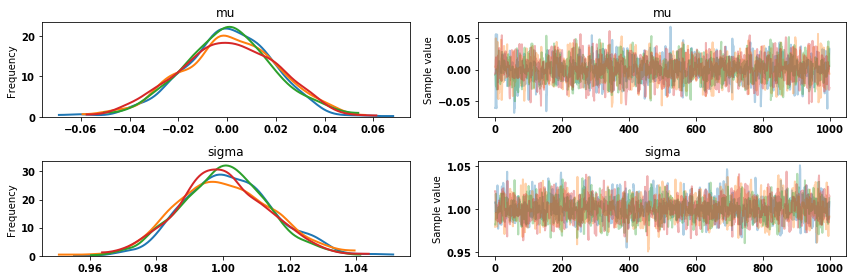

In [30]:
pm.traceplot(trace);

We want to use the samples of $\mu$ and $\sigma$ for further analysis.  To make this further analysis simpler, we extract the samples into a Pandas dataframe.  The following function will do that for us.

In [31]:
def _to_dataframe(trace):
    ft = pd.DataFrame()
    param_list = trace.varnames
    for idx,param_name in enumerate(param_list):
        if "." not in param_name:
            ft[param_name] = trace.get_values(param_name)
        else:
            param_short_name, feature_index = param_name.split(".")
            feature_index = int(feature_index) -1
            if len(fit.extract(param_short_name)[param_short_name].shape) < 2:
                ft[param_name] = fit.extract(param_short_name)[param_short_name]
            else:
                ft[param_name] = fit.extract(param_short_name)[param_short_name][:,feature_index]
    return ft

# Extract the samples to a dataframe called ft
ft = _to_dataframe(trace)
# Print the first five rows of ft
ft.head()

,mu,sigma_log_,sigma
0,-0.061204,0.007871,1.007902
1,-0.061204,0.007871,1.007902
2,0.056245,-0.003423,0.996583
3,-0.055651,0.002797,1.002801
4,-0.061643,-0.000673,0.999327


### How does data generated from the model compare with the actual data?

We see that the model has been fitted without any apparent bad behaviour.  This, however, does not mean that the model fit is of any use.  One way to establish whether the model fit is useful is to compare it with the original data.  

To do this we *generate* new simulated data from the model.  We compare this simulated data with the original data to understand the strengths and weaknesses of this model fit.  

The procedure for generating the simulated data is as follows:

1) select a sample from the posterior distribution of $\mu$ - call this $\mu_{i}$

2) select a sample from the posterior distribution of $\sigma$ - call this $\sigma_{i}$

3) generate a simulated data point by drawing a random number from a normal distribution with mean $\mu_{i}$ and standard deviation $\sigma_{i}$.

For the last stage we use the NumPy's random number module.

In [32]:
# Pre-allocated the generated data vector
generated_data = np.empty(len(ft['mu']))

# for each pair sampled from the posterior of mu and sigma
for idx,m,s in zip(np.arange(len(ft['mu'])),ft['mu'], ft['sigma']):
    generated_data[idx] = np.random.normal(m, s)

generated_data[0:10]

array([-0.76550317, -0.73998738, -0.37751273,  0.49444968, -2.4974832 ,
        3.40835418, -0.41505143, -0.95073431, -0.07784881, -1.86282115])

We can compare the histogram of this *generated* winter temperature data with the original data

In [34]:
%%opts Histogram [tools=['hover'] height=500 width=600] (alpha=0.6)
%%opts Histogram.generate [height=300 width=400] 

# Create a normalised histogram of the daily temperature data
bin_edges = np.linspace(-30,12)
generate_freqs,bin_edges = np.histogram(generated_data, bin_edges, normed=True)

h_generate = hv.Histogram(generate_freqs, bin_edges, 
                  kdims=['Temperature degrees C'], vdims = ['Frequency (%)'],
                  label = 'Generated data')

h1*h_generate

:Overlay
   .Histogram.Winter_daily_mean_temperatures_Pre_hyphen_minus_1990 :Histogram   [Temperature degrees C]   (Frequency (%))
   .Histogram.Generated_data                                       :Histogram   [Temperature degrees C]   (Frequency (%))

We see that the model fit has some issues.  The data generated under the model has too few data points at the extreme cold side. On the other hand, the data generated under the model has too many data points at very warm temperatures.  

Scientifically, this model fit might encourage us to consider whether there is a physical basis for the temperature being skewed towards negative values in Stockholm.  If we think that this negative skewness is physically sound, we could incorporate it in our model using a [skewed normal distribution](https://en.wikipedia.org/wiki/Skew_normal_distribution).


## Markov Chain Monte Carlo (MCMC) sampling

A Markov Chain is a stochastic model describing a sequence of events where each event only depends on the previous event.

Markov Chain Monte Carlo is a type of algorithm that uses Markov Chains to generate samples from a probability distribution.

Both PyMC3 and Stan generate samples from the posterior using a variant of MCMC approach called Hamiltonian Monte Carlo.  In this approach the sampler treats the posterior as a high-dimensional surface and simulates the trajectories of Hamiltonian particles with mass along these surfaces.  The current default in Stan and PyMC3 is to use a sampling algorithm called NUTS.  You can see an example of how this algorithm follows the shape of a target distribution [in this visualisation](https://chi-feng.github.io/mcmc-demo/app.html#EfficientNUTS,donut).

There is an excellent introduction to MCMC sampling in [Chapter 6 of Statistical Rethinking](http://xcelab.net/rm/statistical-rethinking/).  Richard McElreath has also written a blog post about the [differences between NUTS and random walk techniques](http://elevanth.org/blog/2017/11/28/build-a-better-markov-chain/) while Michael Betancourt has written a [more advanced introduction to Hamiltonian Monte Carlo methods](https://arxiv.org/abs/1701.02434).

## Inferring correlation

To infer correlation  $\rho$ between two data vectors $x$ and $y$ we use a similar approach to that above.  In order to infer the correlation parameter we have to assume that $x$ and $y$ have a joint probability distribution. In this case we assume that $x$ and $y$ have a **bivariate** normal probability distribution:
$$ (x,y) \sim \mathcal{N}([\mu_{x},\mu_{y}],\Sigma)$$

where the $\mu_{i}$ values are the means and the covariance matrix is

$$\Sigma = \begin{bmatrix}
    \sigma_{x}^{2} & \rho\sigma_{x}\sigma_{y} \\
     \rho\sigma_{x}\sigma_{y} & \sigma_{y}^{2} \\
\end{bmatrix}$$
The full set of parameters is the mean $\mu_{x}$ and variance $\sigma_{x}^{2}$ of $x$, the mean $\mu_{y}$ and variance $\sigma_{y}^{2}$ of $y$ and the correlation $\rho$ that connects the two dimensions.  

### Who wants to be a weatherman?
We're going to try being a weatherman.  Unfortunately, we have no supercomputer, satellites or radiosondes. Instead, we have a thermometer and an algorithm.  

We want to see how far ahead we can predict the weather simply on the basis of knowing today's weather.  Of course we like a challenge, so we're going to remove the seasonal cycle and try to predict temperature anomalies with respect to the seasonal cycle.

#### Removing the seasonal cycle the easy way
To get this deseasonalised time series, we change our Pandas dataframe to an Xarray Dataset to take advantage of the extra time series functionality in Xarray.  Then we convert the ```anomalies``` output back to a Pandas dataframe again.

In [4]:
# Create an xarray dataset from the pandas dataframe
ds = df.to_xarray()
# Calculate the climatology based on the monthly mean
climatology = ds.groupby('date.month').mean(dim='date')
# Calculate the anomalies with respect to this climatology
anomalies = ds.groupby('date.month') - climatology
# Convert back to a pandas dataframe
anomalies = anomalies.to_dataframe()

If you want an introduction to using Pandas and Xarray for climate scientists [see the material for this workshop](https://github.com/braaannigan/climate_python_intro) that I ran in Stockholm.

In this example we're looking at the autocorrelation of the temperature anomalies in time - that is the correlation between the temperature on a given day and the temperature $\tau$ days later.  

As ever, the first stage is to explore the data visually.  We can now look at the persistance of temperature anomalies as a scatter plot between day 0 on the x-axis and later days on the y-axis.

In [5]:
%%output size=150 # Set figure size
%%opts Scatter (size=3,alpha=0.2)
%%opts Curve (color='black')

# Create a dictionary that maps each value of the offset tau to the scatter plot
scatter_dict = {tau:hv.Scatter((anomalies.temp.iloc[:-tau:10],anomalies.temp.iloc[tau::10]),
                               kdims=["T' on Day 0"], vdims = ["T' on Day tau"]) 
                for tau in np.arange(1,20)} 
# Read the dictionary into a HoloMap and specify the dimension for the slider dimension
scatter = hv.HoloMap(scatter_dict, kdims=['Offset in days']) 
# Add a black line showing perfect persistance
persist = hv.Curve((np.linspace(-20,20),np.linspace(-20,20)))
# Output the scatter plot
scatter*persist

:HoloMap   [Offset in days]
   :Overlay
      .Scatter.I :Scatter   [T' on Day 0]   (T' on Day tau)
      .Curve.I   :Curve   [x]   (y)

The plot suggests that persistance of temperature anomalies is short - just a few days perhaps.

We can estimate the correlation coefficient at different offsets by fitting the bivariate normal model to the temperature anomalies at different offsets.

#### Model compilation
With Stan, the compilation step above is separate from the model fitting step below. Compiling the model can often take longer than fitting the model.  However, the good news is that once we have compiled the model we can then use this compiled version to fit models that match this pattern as many times as we like. 

A further advantage to using Stan is that the compiled object [can be saved to disk and quickly loaded back in the future](http://pystan.readthedocs.io/en/latest/avoiding_recompilation.html).  This saves a lot of time compared to running the model from scratch each time.

Unfortunately, this compilation step is not available in PyMC3.

In [8]:
data_bivariate = {'x':np.vstack((anomalies.temp.iloc[:-5:10],anomalies.temp.iloc[5::10])).T}

In [12]:
def correlation(x, y, 
                mu_prior, sigma_prior, rho_prior,
                samples = 1000, njobs = 2):
    """Get the correlation between x and y
    Inputs:
    x,y - numpy arrays/pandas series of same length
    priors for the parameters
    Ouputs:
    trace - PyMC3 output with results of inference
    rho_range - dictionary setting out mean rho and 95% range
    simulate_data - data simulated under the model
    output trace and summary dictionary"""
    
    def covariance(sigma, rho):
        """Create the covariance matrix from the array sigma and scalar rho"""
        C = ttens.alloc(rho, 2, 2)
        C = ttens.fill_diagonal(C, 1.)
        S = ttens.diag(sigma)
        return ttens.nlinalg.matrix_dot(S, C, S)

    data = np.array([x,y]) # Create a single array with the observed dataset
    with pm.Model() as model:
        # Specify the priors for the means
        mu = pm.Normal('mu', mu = mu_prior['mean'], sd = mu_prior['sd'], shape = 2) 
        # Specify the priors for the variances
        sigma = pm.HalfNormal('sigma', sd = sigma_prior['sd'], shape = 2) 
        # Specify the priors for rho
        rho = pm.Uniform('rho', lower = rho_prior['lower'], upper = rho_prior['upper']) 
        # Create the covariance matrix
        cov = pm.Deterministic('cov', covariance(sigma, rho)) 
        # Specify the likelihood as a multi-variate normal distribution
        mult_n = pm.MvNormal('mult_n', mu = mu, cov = cov, observed = data.T) 
        # Perform the inference and extract 1000 samples from the posterior distributions
        trace = pm.sample(draws = samples, njobs = njobs) 
        # Save some summary statistics for each value of rho
        if 'rho' in pm.stats.quantiles(trace):
            rho_range = {'mean':trace.get_values('rho').mean(),
                         '2.5':pm.stats.quantiles(trace)['rho'][2.5],
                         '97.5':pm.stats.quantiles(trace)['rho'][97.5]}
        else:
            rho_range = {'mean':trace.get_values('rho').mean(),
                         '2.5':pm.stats.quantiles(trace)[0]['rho'][2.5],
                         '97.5':pm.stats.quantiles(trace)[0]['rho'][97.5]}
                
        # Simulate data from the model
        simulate_data = pm.sample_ppc(trace=trace,model=model)
    return trace, rho_range, simulate_data

In the example above we simulated data from the model using NumPy's random number module.  In this case we take
advantage of the in-built feature in PyMC3 that does this for us.  This feature is in the line
```
pm.sample_ppc(trace=trace,model=model)
```


We need to specify prior distributions for the parameters $\mu_{i}$,$\sigma_{i}$ and $\rho$.

We take:
$$\mu_{i} \sim \mathcal{N}(0,1)$$
while
$$\sigma_{i} \sim \mathcal{N}^{+}(0,3)$$
and 
$$\rho \sim \textrm{Uniform(-1,1)}$$

By choosing these prior distributions we are saying that the mean value $\mu$ should be in the range from about -1 to 1, while the standard deviation should be in the range 0-5.  These are an example of *weakly-informative* priors.

In our choice of a uniform prior for $\rho$ we are assigning equal plausiblity to any value between -1 and 1.  This is an example of an *uninformative* prior.

In [9]:
mu_prior_bivariate = {'mean': 0, 'sd': 1}
sigma_prior_bivariate = {'sd': 3}
rho_bivariate = {'lower':-1, 'upper':1}

In [13]:
trace_bivariate,correlation_stats, simulate_data = correlation(anomalies.temp.iloc[:-5:10],
                                                               anomalies.temp.iloc[5::10],
                                                              mu_prior = mu_prior_bivariate,
                                                              sigma_prior = sigma_prior_bivariate,
                                                              rho_prior = rho_bivariate,
                                                              samples = 1000,
                                                              njobs = 4)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho_interval__, sigma_log__, mu]
INFO:pymc3:NUTS: [rho_interval__, sigma_log__, mu]
 11%|█         | 163/1500 [00:09<01:19, 16.90it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '5673' (I am process '5674')
INFO:theano.gof.compilelock:Waiting for existing lock by process '5673' (I am process '5674')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/liambrannigan/.theano/compiledir_Darwin-13.4.0-x86_64-i386-64bit-i386-3.6.3-64/lock_dir
INFO:theano.gof.compilelock:To manually release the lock, delete /Users/liambrannigan/.theano/compiledir_Darwin-13.4.0-x86_64-i386-64bit-i386-3.6.3-64/lock_dir
 11%|█         | 165/1500 [00:09<01:20, 16.60it/s]INFO (theano.gof.compile

As above, the first step is to check that the algorithm didn't produce strange results.

The $R_{\textrm{hat}}$ diagnostic checks to see if the different Markov Chains produced similar results.

In [14]:
pm.diagnostics.gelman_rubin(trace_bivariate)

{'cov': array([[ 0.99966412,  0.9997445 ],
        [ 0.9997445 ,  1.00041566]]),
 'mu': array([ 0.99972285,  0.99968054]),
 'rho': 0.9997202185556695,
 'sigma': array([ 0.99966897,  1.00041522])}

The values here are very close to 1 indicating the various chains have converged to the same posterior distribution.

We also examine $n_{\textrm{eff}}$, the effective number of samples for each parameter.

In [15]:
pm.diagnostics.effective_n(trace_bivariate)

{'cov': array([[ 4000.,  2905.],
        [ 2905.,  4000.]]),
 'mu': array([ 4000.,  4000.]),
 'rho': 3252.0,
 'sigma': array([ 4000.,  4000.])}

In this case we got thousands of samples for each parameter, so we should be able to estimate the quantities of interest.

Finally, we examine the posterior distributions and Markov Chains.

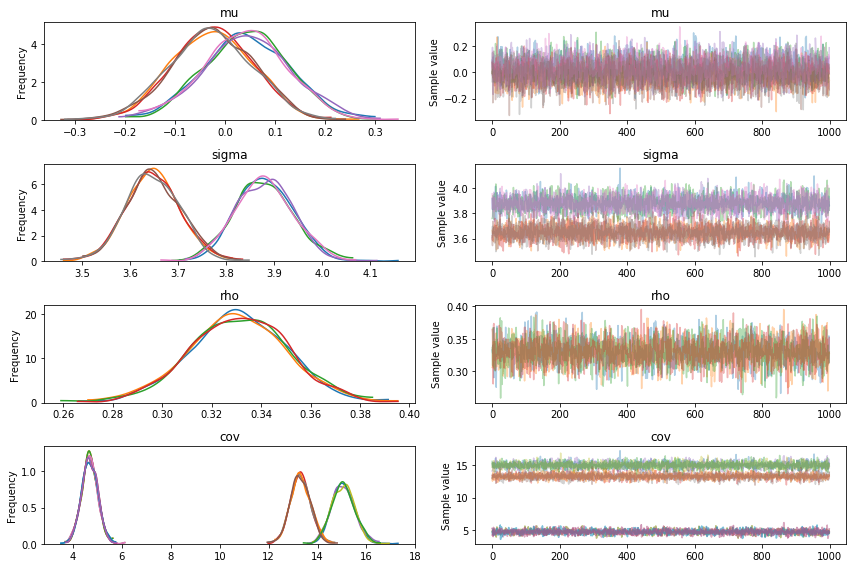

In [16]:
pm.traceplot(trace_bivariate);

The traceplot shows on the left the posterior distributions for the parameters.  The different colours correspond to the 4 different Markov Chains.  The chains did not converge to *exactly* the same posterior distribution, but the correspondance is close enough for our purposes.

The values of $\rho$ are in the range 0.28 - 0.36 with a peak at 0.33.  This suggests a relatively weak but positive correlation between the temperature anomalies on Day 0 and Day 5.

In [19]:
samples_bivariate = pd.DataFrame()
samples_bivariate['mu_1'] = trace_bivariate.get_values('mu')[:,0]
samples_bivariate['mu_2'] = trace_bivariate.get_values('mu')[:,1]
samples_bivariate['sigma_1'] = trace_bivariate.get_values('sigma')[:,0]
samples_bivariate['sigma_2'] = trace_bivariate.get_values('sigma')[:,1]
samples_bivariate['rho'] = trace_bivariate.get_values('rho')
samples_bivariate.head()

,mu_1,mu_2,sigma_1,sigma_2,rho
0,0.093426,-0.010041,3.915280,3.664658,0.332945
1,0.039911,0.015800,3.831266,3.642296,0.328626
2,0.039911,0.015800,3.831266,3.642296,0.328626
3,0.117263,0.066336,3.851225,3.678843,0.340691
4,0.042066,-0.053265,3.895180,3.574503,0.310644


### Checking the model fit
As for the univariate case, we check the model fit by generating data under the model and comparing the results to the real data.

We can compare the properties of this simulated data and the real data for an offset of 5 days.  

In [20]:
%%output size=90
%%opts Scatter (size=7,alpha=0.1) 
%%opts Histogram (alpha=0.5) 

# Set legend position
opts = {'Overlay': {'plot': dict(legend_position='top_left')}}
# Plot simulated model data
model_scatter = hv.Scatter(simulate_data['mult_n'],kdims=['Day 0'], vdims=['Day 5'], label = 'Simulated data')
# Plot real data
data_scatter = hv.Scatter(data_bivariate['x'],kdims=['Day 0'], vdims=['Day 5'], label = 'Real data')
# Combine simulated and real data
overlay = model_scatter.hist(dimension=['Day 0','Day 5'])*data_scatter.hist(dimension=['Day 0','Day 5'])
# Output plot
overlay(opts)

:AdjointLayout
   :Overlay
      .Scatter.Simulated_data :Scatter   [Day 0]   (Day 5)
      .Scatter.Real_data      :Scatter   [Day 0]   (Day 5)
   :Overlay
      .Histogram.Simulated_data :Histogram   [Day 5]   (Day 5_frequency)
      .Histogram.Real_data      :Histogram   [Day 5]   (Day 5_frequency)
   :Overlay
      .Histogram.Simulated_data :Histogram   [Day 0]   (Day 0_frequency)
      .Histogram.Real_data      :Histogram   [Day 0]   (Day 0_frequency)

Overall, fitting a bivariate normal distribution to the temperature anomaly is ok, though the real data is perhaps concentrated closer to 0 and has more extreme values than the data simulated under the model.

We can now fit the model at different time offsets from one to twenty days to see how the autocorrelation varies with a greater lead time. 

We can see how the posterior distribution of $\rho$ varies with the offset time by moving the slider in the plot below.

In [21]:
rho = np.load('data/weather_rho.npy')
n = np.load('data/weather_n.npy')
bin_edges = np.load('data/weather_bin_edges.npy')

In [22]:
%%output size = 130
hv.HoloMap({day:
            hv.Curve((bin_edges[1:],n[:,day-1]),
            kdims=['rho'],vdims=['Probability density']) 
            for day in np.arange(1,21)},
            kdims=['Offset in days'])

:HoloMap   [Offset in days]
   :Curve   [rho]   (Probability density)

We see that the autocorrelation is high on Day 1, but then falls rapidly.  The distribution also becomes broader as the offset is increased.  This broadening of the distribution implies that there is greater uncertainty in the estimate of $\rho$.  We can see this by plotting $\rho$ and its 95% credible range as a function of the offset in time.

In [23]:
# Calculate the mean and the bounds of the 95% credible range
rho_mean = rho.mean(axis=0)
lower = np.percentile(rho,2.5,axis=0)
upper = np.percentile(rho,97.5,axis=0)

To show how the mean and credible range varies as the offset changes we define the plot code below using [Bokeh](https://bokeh.pydata.org/en/latest/).

In [24]:
def corr_uncertainty(est_rho, est_rho_lower, est_rho_upper, title = 'None', 
                     ylabel = 'Correlation', xlabel = 'Offset in days'):
    """Make a bokeh plot to show the probability distribution function for rho compared with its true value
    
    Inputs:
    est_rho: (1d array) - Expectation of rho from model
    est_rho_lower: (1d array) - Lower bound for rho in 95% range
    est_rho_upper: (1d array) - Upper bound for rho in 95% range
    """
    #Have to append a reversed series for the patch coordinates
    x = np.arange(1,est_rho.shape[0]+1)
    band_x = np.append(x, x[::-1])
    band_y = np.append(est_rho_lower, est_rho_upper[::-1])
    p = figure(title= title, height = 500, width = 700)
    p.scatter(x, est_rho, color = 'blue')
    p.patch(band_x, band_y, color='firebrick', fill_alpha=0.5, line_color = "firebrick")
    p.xaxis.axis_label = xlabel
    p.yaxis.axis_label = ylabel
    p.yaxis.bounds = (-2e-1,1)
    show(p)

In [25]:
corr_uncertainty(rho_mean[1:], lower[1:], upper[1:],title="95% credible range for rho")

The inferred range for $\rho$ does indeed drop rapidly.  Perhaps there is a need for the weatherman after all?

If you would like to learn more about Bayesian correlation [see this blog post that I wrote in 2017](https://braaannigan.github.io/bayesian/2017/12/11/bayesian_correlation.html).

## Exercise - get your workflow in order

The examples for fitting a univariate and bivariate distribution above show a simple **workflow** for fitting Bayesian models.  For this exercise, **work in pairs** to set the workflow in order:

1) plot the posterior samples and check $Rhat$ and $n_{\textrm{eff}}$ diagnostics of the model fit

2) compare data generated under the model with the original data

3) visually inspect your data

4) fit the model numerically

5) specify the model mathematically 

The workflow set out here is just a simple example of how you can go about effective statistical modelling.  There are a range of [other visualisation techniques](https://arxiv.org/abs/1709.01449) that you can use to understand the strengths and weaknesses of your model.

# Bayesian inference packages

Bayesian inference packages are going through a rapid stage of development with new packages emerging and new algorithms to drive the packages being developed.  The leading packages are:

In [51]:
bayes_table="""
<table style="width:50%">
  <tr>
    <th>Package</th>
    <th>Interface</th> 
    <th>Backend</th>
  </tr>
  <tr>
    <td>Stan</td>
    <td>R/Python</td> 
    <td>Stan</td>
  </tr>
  <tr>
    <td>PyMC3</td>
    <td>Python</td> 
    <td>Theano</td>
  </tr>
  <tr>
    <td>Edward</td>
    <td>Python</td> 
    <td>TensorFlow</td>
  </tr>
  <tr>
    <td>Pyro</td>
    <td>Python</td> 
    <td>PyTorch</td>
  </tr>

</table>
"""
HTML(bayes_table)

Package,Interface,Backend
Stan,R/Python,Stan
PyMC3,Python,Theano
Edward,Python,TensorFlow
Pyro,Python,PyTorch


The packages differ in terms of their focus.  Stan and PyMC3 are primarily used for fitting statistical models, whereas Edward and Pyro have more of a focus on Bayesian deep learning.  The packages are also optimised for different computational environments.  Stan was developed originally to run on standard computers.  The TensorFlow and PyTorch backends for Edward and Pyro, on the other hand, were developed from the outset with GPU optimizations.
Adding GPU capability to Stan is [an on-going project](http://discourse.mc-stan.org/t/stan-on-the-gpu/326/5).

There are also some older packages such as JAGS and BUGS that use less efficient MCMC methods.  It is strongly recommended that a newer package like Stan is used instead as this may lead to much faster inferences.